# Utils

In [1]:
class Sampler:
  """Utility class to store sampled data"""
  INTERVAL = 5

  def __init__(self):
    self._history = {}

  def get_sample(self, name):
    return self._history[name] if name in self._history else None

  def get_history(self):
    return self._history

  def sample(self, iteration, name, val):
    if iteration % Sampler.INTERVAL != 0:
      return

    if name in self._history:
        self._history[name].append(val)
    else:
        self._history[name] = [val]

In [2]:
def create_confusion_matrix(y_true, y_pred, dim=10):
  m = len(y_true)

  confusion_matrix = np.zeros((dim, dim), dtype=np.uint32)
  for i in range(m):
    confusion_matrix[y_true[i], y_pred[i]] += 1

  return confusion_matrix

def plot_confusion_matrix(actual, predicted, dim=10, *, title=None, class_names=None):
    cm = create_confusion_matrix(actual, predicted, dim)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def calculate_accuracy(y_true, y_pred, dim=10):
    cm = create_confusion_matrix(y_true, y_pred, dim)
    return np.trace(cm) / cm.sum()

def generate_confusion_table(cm, cls):
  ct = np.zeros((2,2))

  TP = cm[cls, cls]
  FP = cm[:, cls].sum() - TP
  FN = cm[cls, :].sum() - TP
  TN = cm.sum() - TP - FP - FN

  ct[0,0] = TP
  ct[0,1] = FN
  ct[1,0] = FP
  ct[1,1] = TN

  return ct

# Dataset loading


In [3]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# load the MNIST dataset.
mnist = fetch_openml('mnist_784', version=1)

<Axes: xlabel='class', ylabel='count'>

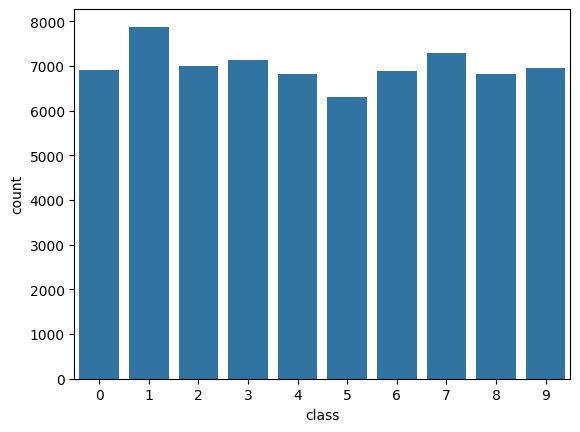

In [5]:
N_SAMPLES = 10_000
x, y = mnist['data'], mnist['target']
Y = y.to_numpy().astype(float)
m_rows, n_cols = x.shape

# Plot the count of each label
sns.countplot(y.to_frame(), x='class')

In [6]:
# Create the features matrix X and add the bias element to each row
mat_X = np.c_[np.ones(x.shape[0]), x.to_numpy()]
mat_X

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], shape=(70000, 785))

In [7]:
# Hot encode y.
Y_hot = np.zeros(shape=(m_rows, 10), dtype=float)
# Go over each row and place 1 at the index of the label, i.e label 3 will be placed at the 3rd index.
Y_hot[range(m_rows), Y.astype(int)] = 1
Y_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(70000, 10))

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(mat_X, Y_hot, test_size=0.2, random_state=42)
f"X_train{X_train.shape}, X_test{X_test.shape}, Y_train{Y_train.shape}, Y_test{Y_test.shape}"

'X_train(56000, 785), X_test(14000, 785), Y_train(56000, 10), Y_test(14000, 10)'

In [9]:
y_lables = np.argmax(Y_train, axis=1)
y_lables

array([5, 4, 8, ..., 1, 0, 0], shape=(56000,))

# Part A - The perceptron learning algorithm

In [10]:
class PLA(Sampler):
  """Perceptron Learning Algorithm"""

  def __init__(self, max_epochs = 100):
    super().__init__()
    self.max_epochs = max_epochs

  def fit(self, X, Y):
    m, n_features = X.shape

    # Create the weights-bias combined vector (the bias is the first elem of each row)
    self._wb = np.zeros(n_features)
    self.pocket = self._wb
    min_err = np.nan

    for epoch in tqdm(range(self.max_epochs)):
      yh = self._vectorized_predict(X)

      # Get the misclassified indexes
      misclassified_idxs = (Y != yh)

      # Sum will give use the number of errors, as it treats True as 1 and False as 0
      # thus, we can count the number of trues to get the number of errors.
      n_errors = misclassified_idxs.sum()

      # Save the min error for the pocket algorithm.
      if np.isnan(min_err) or n_errors < min_err:
          min_err = n_errors
          self.pocket = self._wb.copy()

      self.sample(epoch, 'errors', n_errors)

      # If there are no misclassified examples then we can break out of the loop.
      if n_errors == 0:
          break

      # M = { i | y_i != yh_i }
      # update = ∑{i∈M} y_i*x_i
      update = Y[misclassified_idxs] @ X[misclassified_idxs]
      self._wb += update

  def _vectorized_predict(self, X):
    """Makes a vectorized prediction"""
    return np.sign(X @ self._wb)

  def get_wb(self):
    """Returns the pocket weights"""
    return self.pocket

In [11]:
class PLAOneVsAll:
  def __init__(self, max_epochs = 100):
    self.max_epochs = max_epochs
    # Save the classifiers to plot the training Ein
    self._classifiers = []

  def fit(self, X, Y):
    m, n_features = X.shape
    n_classes = Y.shape[1]
    self.w_mat = np.zeros(shape=(n_classes, n_features))

    y_signed = np.where(Y == 0, -1, 1)
    for dig in tqdm(range(n_classes)):
      classifier = PLA(self.max_epochs)
      # Run the classifier on the current digit
      classifier.fit(X, y_signed[:, dig])
      # Save the pocket weights in w_mat
      self.w_mat[dig] = classifier.get_wb()
      self._classifiers.append(classifier)

  def predict(self, X):
    """Gets the class with the highest confidence score"""
    return (self.w_mat @ X.T).argmax(axis=0)

  def get_classifiers(self):
    """Returns the classifiers"""
    return self._classifiers

In [12]:
one_vs_all = PLAOneVsAll(200)
one_vs_all.fit(X_train, Y_train)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

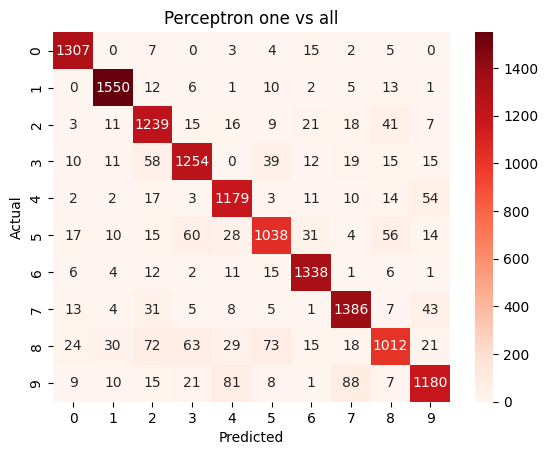


Accuracy: 89.16428571428571%


In [13]:
y_true = Y_test.argmax(axis=1)
y_pred = one_vs_all.predict(X_test)

plot_confusion_matrix(y_true, y_pred, title="Perceptron one vs all", class_names=range(10))
print(f"\nAccuracy: {calculate_accuracy(y_true, y_pred) * 100}%")

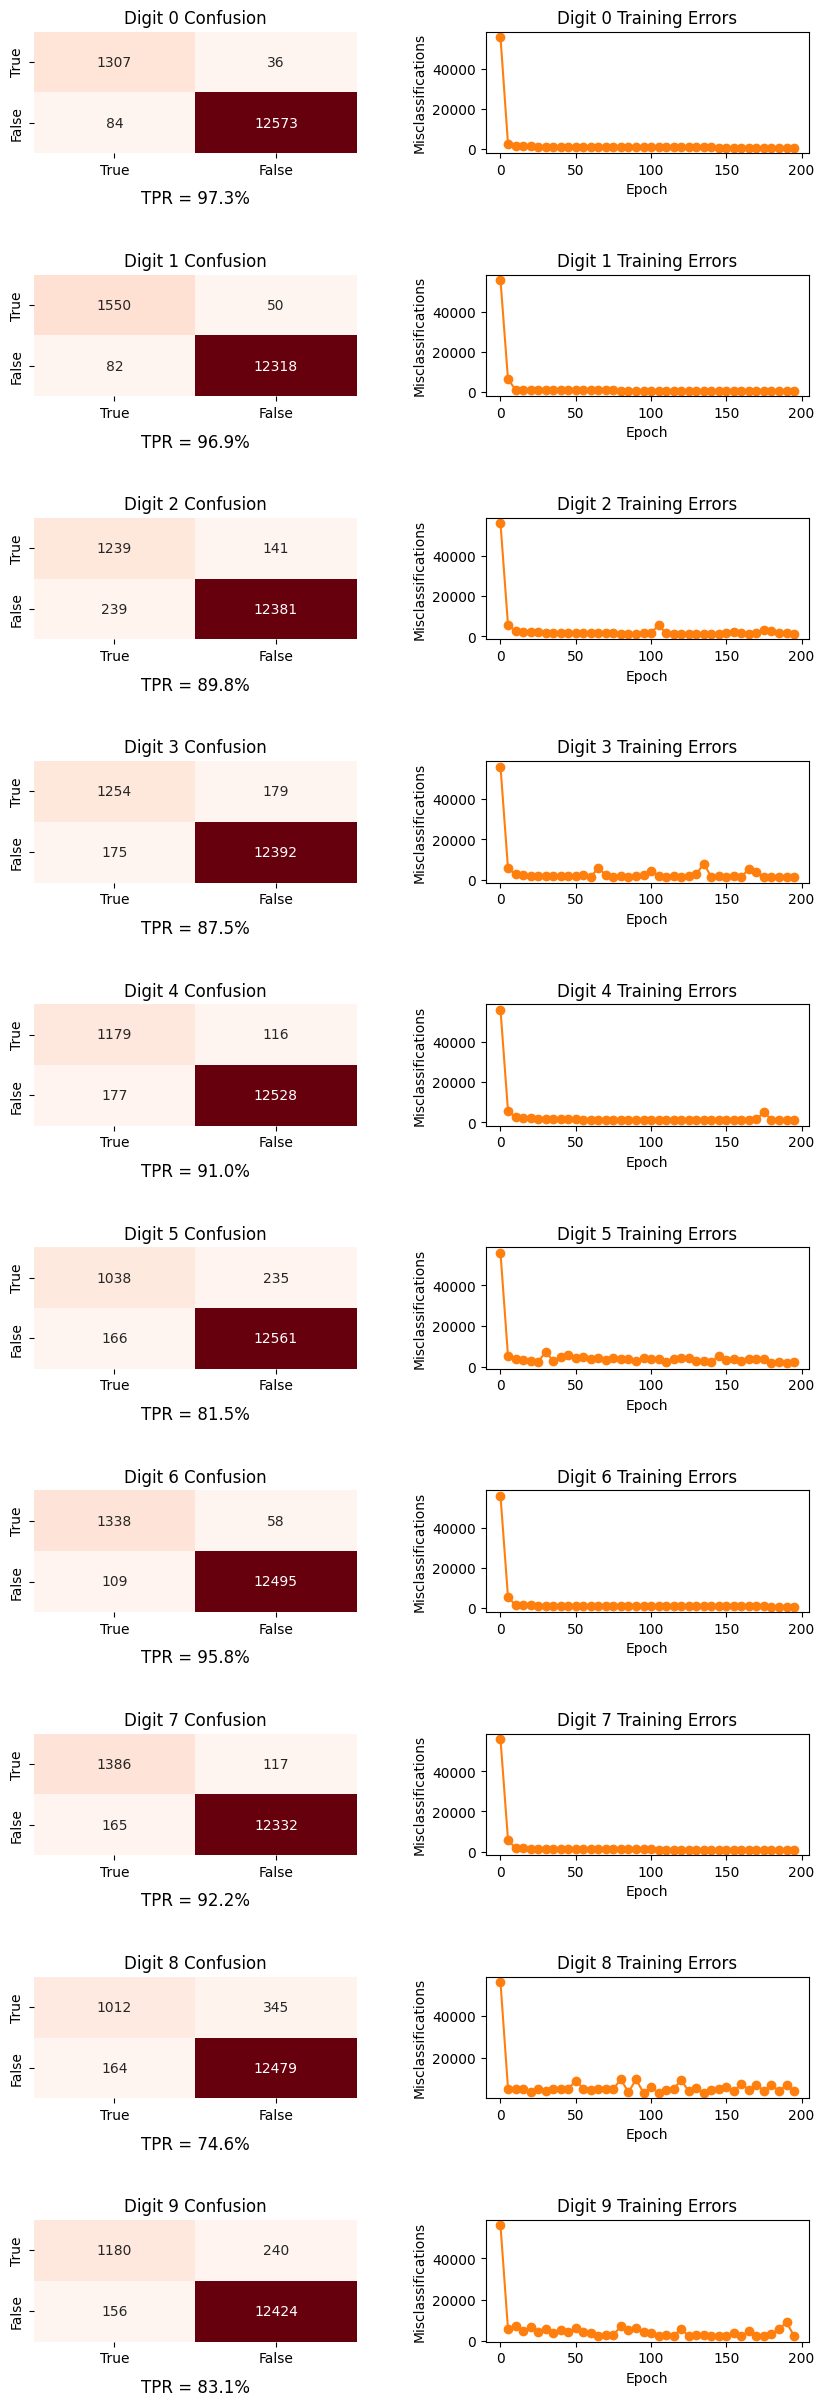

In [14]:
# Create the confusion matrix
cm = create_confusion_matrix(y_true, y_pred)

# Create the confusion table for each digit
ct_of_classes = [generate_confusion_table(cm, i).astype(int) for i in range(10)]

# Create a DataFrame, will hold the TPR of each digit
df = pd.DataFrame(range(10), columns=["Digits"])
df["TPR"] = np.nan

for cls in range(10):
  ct = ct_of_classes[cls]
  TP = ct[0, 0]
  FN = ct[0, 1]

  # Updates the TPR for the current digit in the DataFrame
  df.loc[cls, "TPR"] = TP / (TP + FN)

tprs = df["TPR"].to_list()
plas = one_vs_all.get_classifiers()
# Gather all the histories of each classifier
histories = [np.array(pl.get_history()['errors']) for pl in plas]
max_len = max(len(classifier.get_sample("errors")) for classifier in one_vs_all.get_classifiers())
epochs = np.arange(max_len) * Sampler.INTERVAL

fig, axes = plt.subplots(10, 2, figsize=(10, 30))
plt.subplots_adjust(hspace=1.0, wspace=0.4)

# Plot the confusion table and the training errors/loss for each digit
# the TPR is also displayed below
for d in range(10):
    ax_cm = axes[d, 0]
    sns.heatmap(
        ct_of_classes[d],
        annot=True, cbar=False, fmt="d", cmap="Reds",
        xticklabels=["True", "False"],
        yticklabels=["True", "False"],
        ax=ax_cm
    )
    ax_cm.set_title(f"Digit {d} Confusion")
    ax_cm.set_xlabel("")
    ax_cm.set_ylabel("")

    ax_err = axes[d, 1]
    errs = histories[d]
    ax_err.plot(epochs[:len(errs)], errs, marker='o', color='tab:orange')
    ax_err.set_title(f"Digit {d} Training Errors")
    ax_err.set_xlabel("Epoch")
    ax_err.set_ylabel("Misclassifications")

    ax_cm.text(
        0.5, -0.3,
        f"TPR = {tprs[d]*100:0.1f}%",
        ha="center", va="top",
        transform=ax_cm.transAxes,
        fontsize=12
    )

plt.show()

## Evaluation

* **Accuracy:**
  * As we can see, digits that have relatively low TPR have more fluctuation in their graphs meaning that it maybe be harder to linearly sperate them from the rest of the samples, thus the seperating line is less accurate, which leads in turn to relatively lower TPR.

  * Looking at the results we can notice that the digits '3', '5', '8' and '9' have low TPR, this is expected because these digits are somewhat similar to each other, thus their pixels in the dataset are probably positioned at similar locations which makes them harder be linear seperable.

* **Time:**
  * The Pocket algorithm saves us time, because as we can see the error rate is almost at its lowest somewhere between the 50-100 epoch, thus we can try to run the algorithm for less epochs and still get good results.

# Part B - Softmax Regression

In [15]:
class SoftmaxRegression(Sampler):
  def __init__(self, max_epochs = 1000, *, grad_tresh=1e-5, ein_tresh=1e-5, eta=0.1):
    super().__init__()

    self._max_epochs = max_epochs
    self._eta = eta
    self._grad_tresh = grad_tresh
    self._ein_tresh = ein_tresh

  def fit(self, X, Y):
    m, n_features = X.shape
    n_classes = Y.shape[1]

    self._wb = np.random.randn(n_classes, n_features) * 0.01
    for epoch in tqdm(range(self._max_epochs)):
      YH = self.predict(X)
      grad = self._grad(Y, YH, X)
      self._wb -= self._eta * grad

      cross_entropy = self._cross_entropy(Y, YH)
      if np.linalg.norm(grad) < self._grad_tresh or cross_entropy < self._ein_tresh:
          break

      self.sample(epoch, 'cross_entropy', cross_entropy)

  def _softmax(self, X):
    """Softmax function"""
    exp_x = np.exp(X)
    return exp_x / exp_x.sum(axis=0, keepdims=True)

  def _grad(self, Y, YH, X):
    """Calcualte the gradient"""
    return (YH - Y).T @ X / X.shape[0]

  def predict(self, X):
    """Makes a prediction"""
    return self._softmax(self._wb @ X.T).T

  def _cross_entropy(self, Y, YH):
    """Evaluate the cross entropy"""

    # y is one-hot encoded, hence, we can simplify the equation that is given in the instructions
    # because if we calculate y * log(expr) we will only get the result from the element which is tagged as '1' in the one-hot encoded vector.
    return -np.mean(Y * np.log(YH))


In [16]:
X_normalized = X_train / 255.0
s = SoftmaxRegression(1000, eta=0.5)
s.fit(X_normalized, Y_train)

  0%|          | 0/1000 [00:00<?, ?it/s]

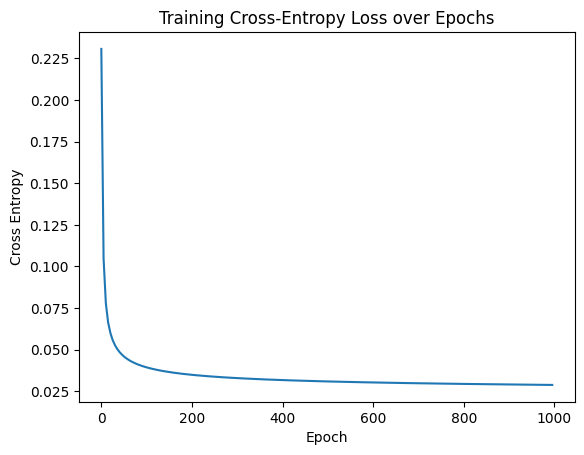

In [17]:
values = s.get_sample("cross_entropy")
epochs = np.arange(len(values)) * Sampler.INTERVAL

df = pd.DataFrame({
    "Epoch": epochs,
    "Cross Entropy": values
})

sns.lineplot(x="Epoch", y="Cross Entropy", data=df)
plt.title("Training Cross-Entropy Loss over Epochs")
plt.show()

## Discussion points
* **Rapid initial decline:**
  * We can see that the cross-entropy loss plunges quite sharply at the first 10-100 epochs, we can assume that this is because the models learns quickly the bulk of the structure of the data.

* **Plateau:**
  * After the sharp decline in the first 100 epochs, we can see that the graph flattens and that the gradual decline becomes quite negligble after the 800 epochs, we can maybe change the max_epochs parameter to be 800 and still get similar results.

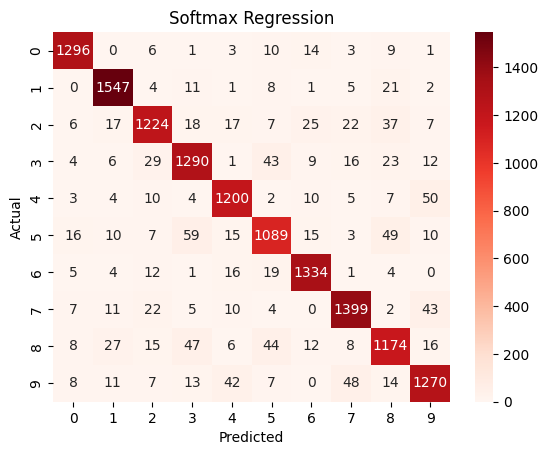


Accuracy: 91.59285714285714%


In [18]:
# I normalized the pixels because when i tried to leave it as is it
# caused numeric overflow issues...
X_test_normalized = X_test / 255.0

cm = create_confusion_matrix(Y_test.argmax(axis=1), s.predict(X_normalized).argmax(axis=1))
plot_confusion_matrix(Y_test.argmax(axis=1), s.predict(X_test_normalized).argmax(axis=1), title="Softmax Regression", class_names=range(10))
print(f"\nAccuracy: {calculate_accuracy(Y_test.argmax(axis=1), s.predict(X_test_normalized).argmax(axis=1)) * 100}%")

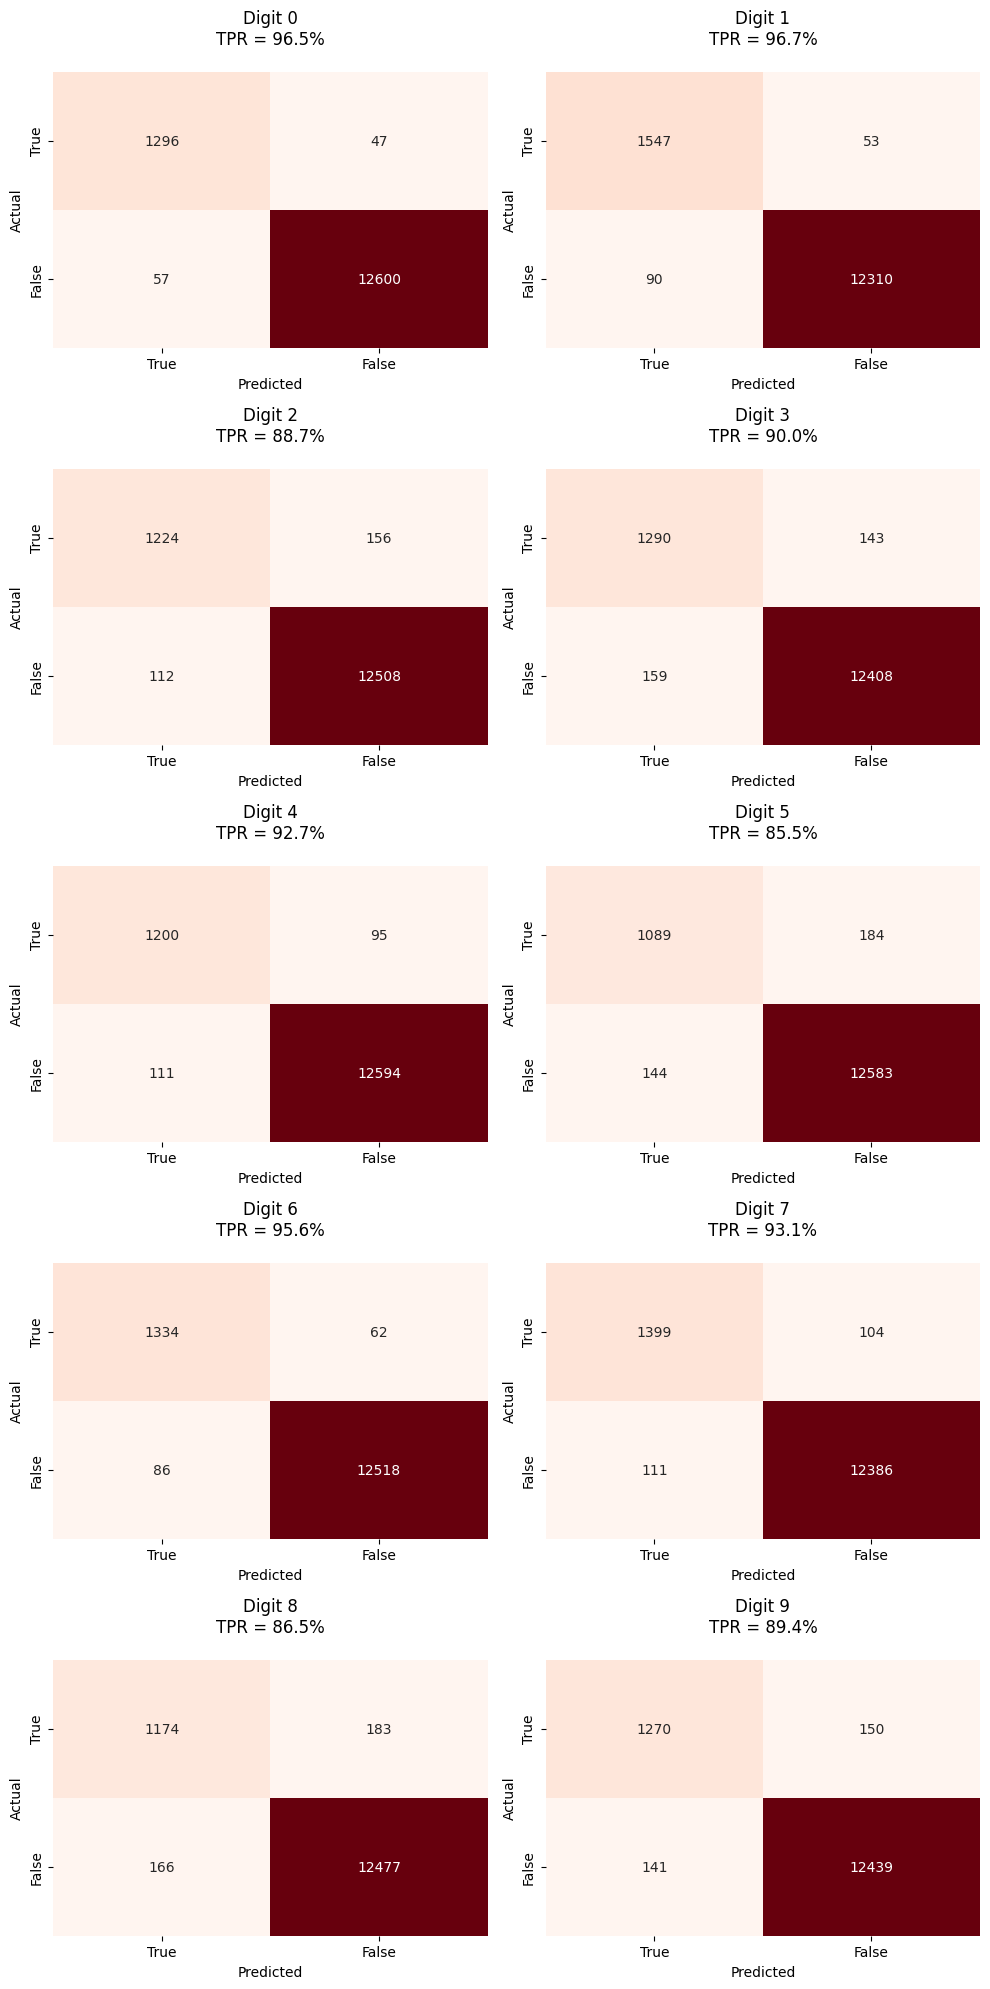

In [19]:
cm = create_confusion_matrix(Y_test.argmax(axis=1), s.predict(X_test_normalized).argmax(axis=1))
ct_of_classes = [generate_confusion_table(cm, i) for i in range(10)]
df = pd.DataFrame(range(10), columns=["Digits"])
df["TPR"] = np.nan

for cls in range(10):
  ct = ct_of_classes[cls]
  TP = ct[0, 0]
  FN = ct[0, 1]
  df.loc[cls, "TPR"] = TP / (TP + FN)

fig, axes = plt.subplots(5, 2, figsize=(10, 20))
axes = axes.ravel()

for cls in range(10):
    ax = axes[cls]
    ct = ct_of_classes[cls]

    # Plot the heatmap/confussion table for each digit
    sns.heatmap(
        ct,
        annot=ct.astype(int),
        fmt='d',
        cmap='Reds',
        cbar=False,
        xticklabels=['True', 'False'],
        yticklabels=['True', 'False'],
        ax=ax
    )

    ax.set_title(f"Digit {cls}\nTPR = {df.loc[cls, 'TPR']*100:.1f}%", pad=20)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

## Evaluation

* **Accuracy:**
  * Softmax regression learns all of the ten labels without the need to use the OneVsAll strategy as we did for the PLA, we can see that the results of it are better then those that we got from the OneVsAll PLA model.

  * The Softmax regression model is able to achieve higher accuracy because the Softmax function is Convex thus we know that there is a global min that we can reach, whereas in the PLA case the target function is NP Complete and thus we can only try to get a rough approximate of it.

  * As for the PLA case we can see that even this model experiences harder time to differentiate between digits that are somewhat similar, e.g. '3', '5', '8' and '9' though its performance is superior to that of the PLA.

* **Performance:**
  * The Softmax regression model runs slower than the PLA, this is expected because it also have to calculate the Gradient whereas the PLA does not.

* **Practical Takeaways:**
  * Softmax gives you one weight matrix instead of ten separate perceptrons, simplifying deployment and inference.  
  
  * We gain calibrated scores for each class that can drive threshold-based decisions or uncertainty estimates.  
  
  * Monitor validation cross-entropy and halt training once improvements fall below a small threshold—Softmax’s convex loss makes this process straightforward and robust.

# Part C - Linear Regression

In [20]:
class LinearRegression:
  def __init__(self, X, Y):
    # I tried the closed form approach, but it fails to work
    # as (X.T @ X) does not result in a Singular matrix.
    # After consulting with ChatGPT he told me that i can use np.linalg.pinv instead.
    # This function provides us with the Moore-Pensrose pseudo-inverse matrix of X,
    # If we have some equation system Ax = b, then the pseudo matrix A' uphold, A*A' = b

    # self._wh = np.linalg.inv(X.T @ X) @ X.T @ Y

    # pinv(X) = some X' such that X'Y = wh, where wh is a solution to the residual square sum problem.
    self._wh = np.linalg.pinv(X) @ Y

  def predict(self, X):
    return X @ self._wh

In [21]:
lr = LinearRegression(X_train, Y_train)

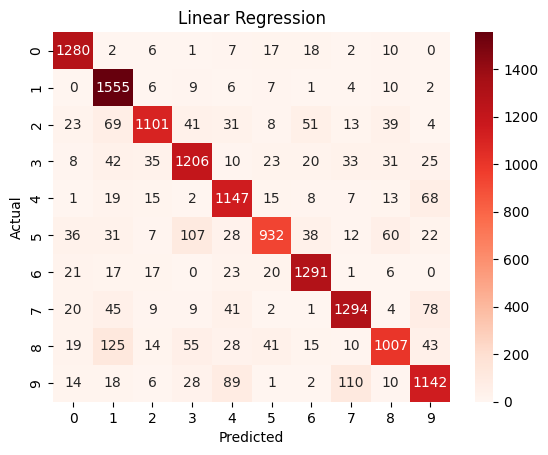


Accuracy: 85.39285714285715%


In [22]:
cm = create_confusion_matrix(Y_test.argmax(axis=1), lr.predict(X_test).argmax(axis=1))
plot_confusion_matrix(Y_test.argmax(axis=1), lr.predict(X_test).argmax(axis=1), title="Linear Regression", class_names=range(10))
print(f"\nAccuracy: {calculate_accuracy(Y_test.argmax(axis=1), lr.predict(X_test).argmax(axis=1)) * 100}%")

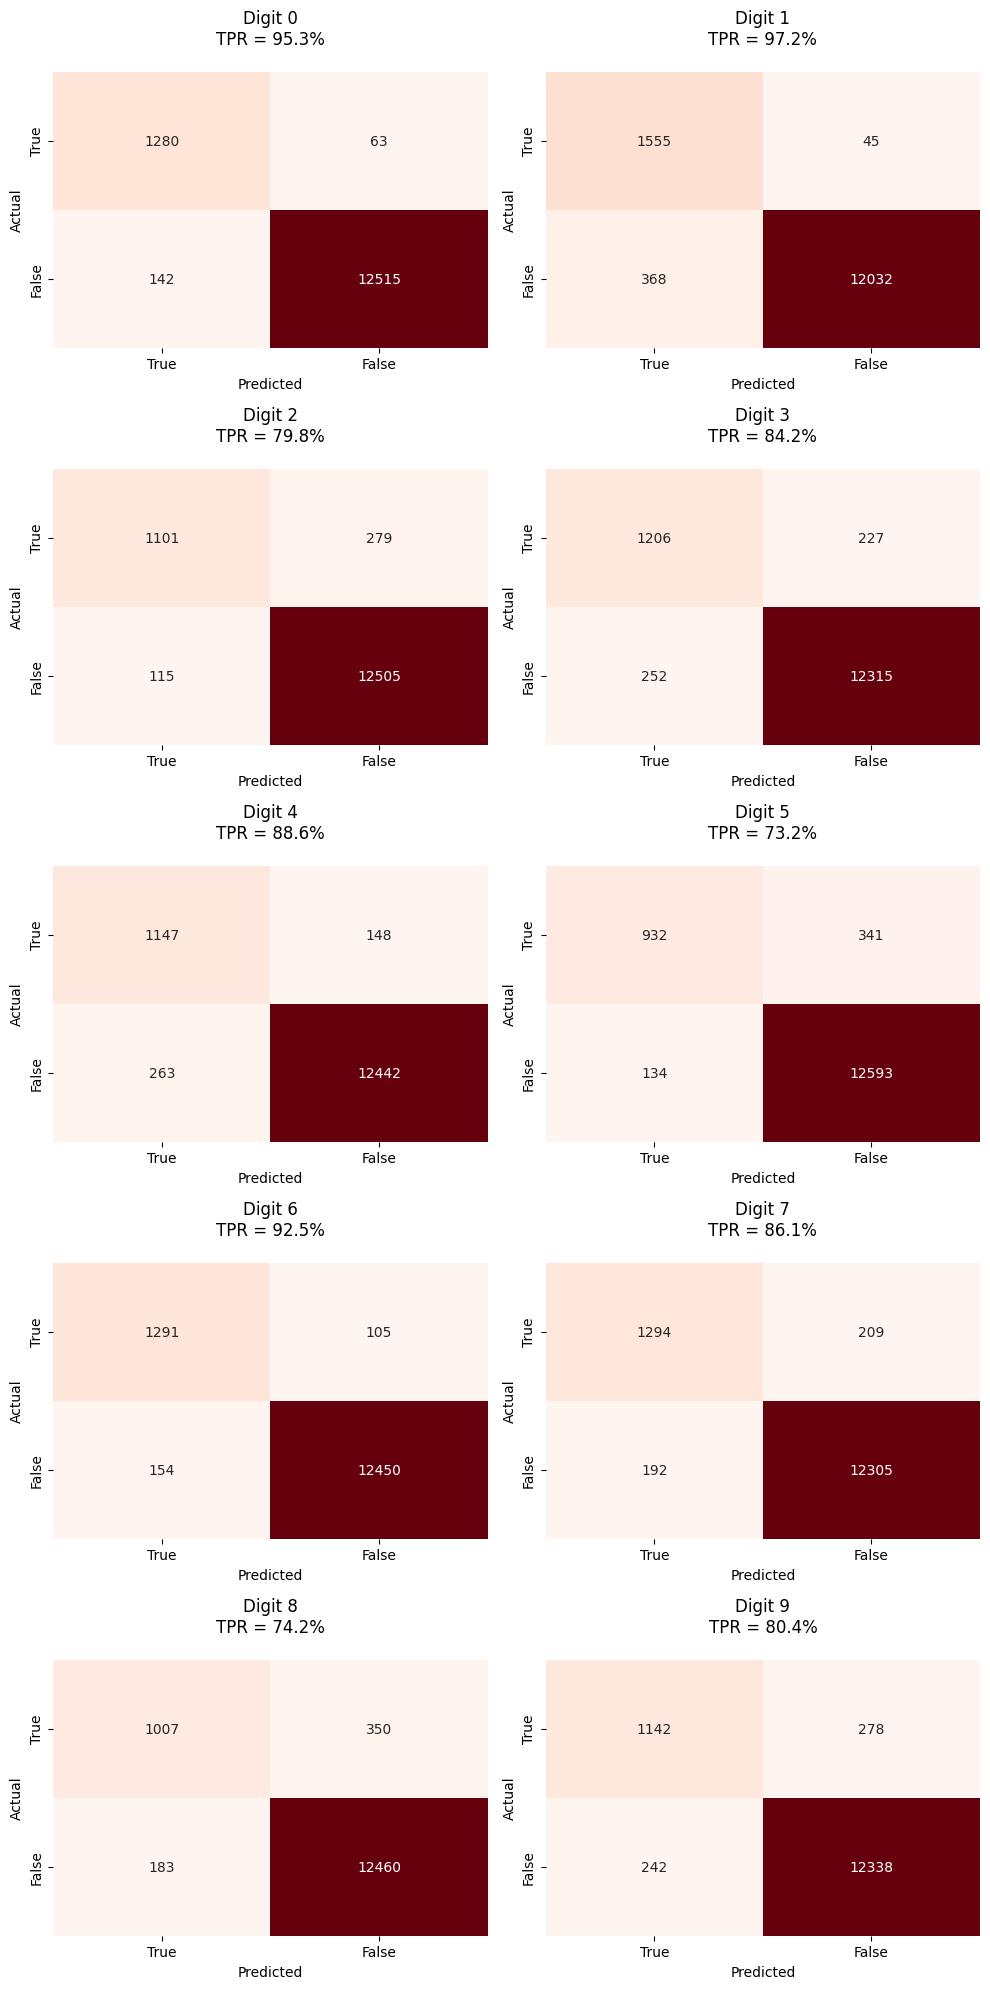

In [23]:
cm = create_confusion_matrix(Y_test.argmax(axis=1), lr.predict(X_test).argmax(axis=1))
ct_of_classes = [generate_confusion_table(cm, i) for i in range(10)]
df = pd.DataFrame(range(10), columns=["Digits"])
df["TPR"] = np.nan

for cls in range(10):
  ct = ct_of_classes[cls]
  TP = ct[0, 0]
  FN = ct[0, 1]
  df.loc[cls, "TPR"] = TP / (TP + FN)

fig, axes = plt.subplots(5, 2, figsize=(10, 20))
axes = axes.ravel()

for cls in range(10):
    ax = axes[cls]
    ct = ct_of_classes[cls]

    # Plot the heatmap/confussion table for each digit
    sns.heatmap(
        ct,
        annot=ct.astype(int),
        fmt='d',
        cmap='Reds',
        cbar=False,
        xticklabels=['True', 'False'],
        yticklabels=['True', 'False'],
        ax=ax
    )

    ax.set_title(f"Digit {cls}\nTPR = {df.loc[cls, 'TPR']*100:.1f}%", pad=20)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

## Evaluation

* **Accuracy:**
  * Linear Regression treats class labels as numeric targets and minimizes squared error, not classification loss. As a result, it only achieves 88.4% accuracy—lower than both Softmax (≈92–93 %) and PLA (~90 %).

  * The worst TPRs occur on digits with similar shapes (e.g. 2, 3, 5, 8, 9), mirroring patterns seen in the other models but with amplified misclassification rates.

* **Performance:**
  * Training is essentially instantaneous: a single call to np.linalg.pinv and one matrix multiplication produce the weight vector in one shot—no epochs or iterative updates required.

  * This makes Linear Regression the fastest of the three, ideal for quick baselines or when compute is severely constrained.

* **Practical Takeaways:**
  * Provides a rapid linear baseline to gauge how much classification-specific objectives improve performance.